# Часть 1. Проверка гипотезы в Python и составление аналитической записки

## Напишите заголовок первой части проекта здесь

- Автор: Шепелев А.Д.
- Дата: 10.06.2025

## Цели и задачи проекта

Цель проекта - проверка гипотезы: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. 

## Описание данных

Для работы нам предоставлен датасет `yandex_knigi_data.csv`:
- `Unnamed` - индекс
- `city` - название города
- `puid` - индентификатор пользователя
- `hours` - количество часов прослушивания

## Содержимое проекта

- Знакомство с данными: загрузка и обработка
- Проверка гипотезы
- Итоговый вывод

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil
from scipy import stats as st
import statsmodels.api as sm

In [2]:
df_book = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')
df_book.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [3]:
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [4]:
# Проверка дубликатов по пользователям

print(f"Количество дубликатов в столбце [puid]: {df_book.duplicated(subset='puid').sum()}")
print(f"Доля дубликатов от всего датасета: {(df_book.duplicated(subset='puid').sum() / df_book['puid'].count()).round(2)}")

Количество дубликатов в столбце [puid]: 244
Доля дубликатов от всего датасета: 0.03


Доля дубликатов составляет 3% от всего датасета - удалить будет оптимальным решением.

In [5]:
# Удалим дубликаты
df_book = df_book.drop_duplicates(subset='puid', keep = 'first')

In [6]:
# Проверим результат
df_book.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8540 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8540 non-null   int64  
 1   city        8540 non-null   object 
 2   puid        8540 non-null   int64  
 3   hours       8540 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 333.6+ KB


In [7]:
# Проверим размеры групп

city_users = df_book.groupby('city')['puid'].count().reset_index()

msk_users = city_users.loc[city_users['city'] == 'Москва', 'puid'].values[0]
spb_users = city_users.loc[city_users['city'] == 'Санкт-Петербург', 'puid'].values[0]

city_diff = round(100 * (msk_users - spb_users) / msk_users, 2)

print(f"Количество пользователей Москвы: {msk_users}")
print(f"Количество пользователей Санкт-Петербурга: {spb_users}")
print(f"Процентная разница между группами: {city_diff}%")

Количество пользователей Москвы: 6234
Количество пользователей Санкт-Петербурга: 2306
Процентная разница между группами: 63.01%


In [8]:
# Выведем осноные статистические данные
df_book.groupby('city')['hours'].describe()

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Москва,6234.0,10.881092,36.851683,0.000018,0.059903,0.924498,5.939972,857.209373
Санкт-Петербург,2306.0,11.264433,39.831755,0.000025,0.060173,0.875355,6.138424,978.764775


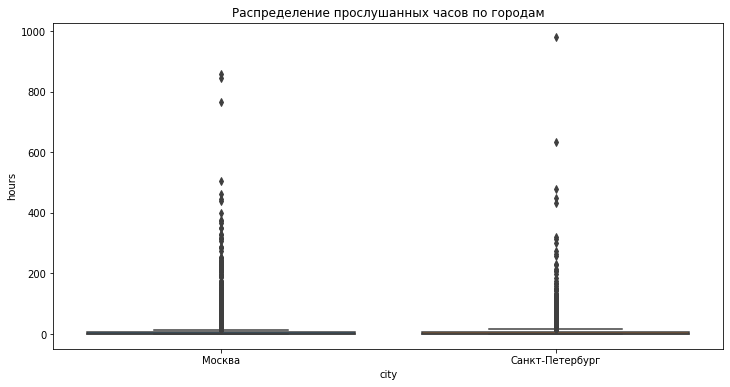

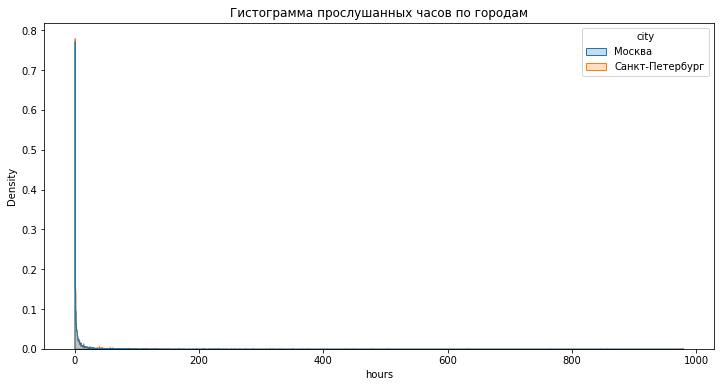

In [9]:
# Построим коробчатую диаграмму
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='hours', data=df_book)
plt.title('Распределение прослушанных часов по городам')
plt.show()

# Построим гистограмму
plt.figure(figsize=(12, 6))
sns.histplot(data=df_book, x='hours', hue='city', element='step', stat='density', common_norm=False)
plt.title('Гистограмма прослушанных часов по городам')
plt.show()

По итогам предобработки данных было удалено 3% данных от всего датасета, получен датасет в 8540 строк.
Соотношение пользователей из Москвы и Санкт-Петербурга больще уходит в сторону Москвы, процентная разница составляет 63%.
Группы имеют схожие распределения пользователей по количеству прослушанных часов. В Санкт-Петербурге замечается большее количество выбросов т.к. среднее у пользователей Петербурга немного выше - 11.26 часов. 

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не больше.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Для проверки гипотезы нам подойдёт t-тест для независимых выборок:
- Группы из Санкт-Петербурга и Москвы не связаны друг с другом → они независимы;
- Выборки достаточно большие, t-тест можно применить даже при отклонении от нормальности;
- Поскольку гипотеза предполагает, что время пользователей из Санкт-Петербурга больше, нам нужен односторонний тест.

In [10]:
# Проверяем гипотезу

msk_group = df_book[df_book['city'] == 'Москва']['hours']
spb_group = df_book[df_book['city'] == 'Санкт-Петербург']['hours']

alpha = 0.05 #Возьмём стандартное значение уровня значимости

results = st.ttest_ind(
    spb_group,
    msk_group, 
    alternative='greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: различия статистически значимы.')
else:
    print('Не отвергаем нулевую гипотезу: различия не статистически значимы.')

p-значение: 0.338193679651558
Не отвергаем нулевую гипотезу: различия не статистически значимы.


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



По результатам t-теста для двух независимых выборок и стандартным уровнем значимости - 0.05 получено значение p-value - 0.34, что не подтвердило альтернативную гипотезу.

На большее среднее значение часов в Санкт-Петербурге могли повлиять очень активные пользователи (выбросы), что видно на графиках.

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Цель - проверка корректности проведения теста и анализ его результатов.

## 2. Загрузите данные, оцените их целостность.


In [11]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [12]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [13]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


Датасет не содержит пропусков, информация в столбцах соответствует названию.

In [14]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [15]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


Датасет содержит пропуски в столбце `details` что не является проблемой, так как столбец предполагает пропуски, информация в столбцах соответствует названию.

Проверим датасет на наличие явных дубликатов.

In [16]:
duplicate_events = events[events.duplicated(keep='first')]
duplicate_events

,user_id,event_dt,event_name,details
50,A39D63750BBE9B34,2020-12-01 00:08:24,login,NaN
132,631020621D23464A,2020-12-01 00:25:03,login,NaN
278,AD6541E75198ABEF,2020-12-01 00:48:46,login,NaN
390,ADBBC43BED1249C8,2020-12-01 01:06:02,product_cart,NaN
446,928AD890A8E7BDE7,2020-12-01 01:11:10,login,NaN
...,...,...,...,...
787141,GLOBAL,2020-12-31 23:21:18,purchase,4.49
787200,GLOBAL,2020-12-31 23:36:55,purchase,4.49
787209,GLOBAL,2020-12-31 23:39:41,product_cart,NaN
787217,F9C2F1ECC9624248,2020-12-31 23:42:17,product_page,NaN


In [17]:
events = events.drop_duplicates(keep='first')
events

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN
...,...,...,...,...
787281,1A655C280B064708,2020-12-31 23:57:44,product_page,NaN
787282,B77B2F4BCA134618,2020-12-31 23:58:23,registration,0.0
787283,GLOBAL,2020-12-31 23:58:30,product_cart,NaN
787284,B12AD1623E494FAD,2020-12-31 23:58:34,registration,-6.52


После предобработки удалено 36318 строк из датасета `events`. Размер датасета после предобработки - 750968 строк.

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [18]:
participants['ab_test'].unique()

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

In [19]:
# Проверим тесты на пересечение пользователей
df_inteface = participants[(participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'B')]['user_id']
df_recommend = participants[(participants['ab_test'] == 'recommender_system_test') & (participants['group'] == 'B')]['user_id']

intersection = list(set(df_inteface) & set(df_recommend))
print(intersection) 

['70CE04E185154AD7', '84AAB026310D49C4', 'C4F3A9D7BB596E6E', '565EF59DDD36B95B', 'FFF28D02B1EACBE1', '88FB1EDF3E249223', '75013CAAF42E90A9', 'AEB9B39AE54D3598', '4B34A5BD1D1AEF0D', '739656E0D7B50B30', 'BF1EB8E6FA3F19B8', '13AA9B89A2885F8E', '38189578561F38CB', '23F551153080EBAB', 'E3780F6861A69868', '4FE90CB247C78EC5', '9F0571C70D4BD33B', 'C7750723906C925A', 'C74B6E95352ADE79', '53732758D90FB1E4', '63F5FC15B31DB5A6', '3A6D88AB973BD99D', 'E7CC63BF20618321', '0FBF679EA1340786', '5207E56E697027E9', '2D6A6472D7F46812', 'BEF16764A13AEC34', '13FBEB715F4AAE10', 'EF449601C94D2496', 'C0924D3FF1BEAA05', '4122B8F30EB2271C', '24FB1A84E1C30291', '0A0141A363E2E051', '649CE5D5A38BFA8B', 'A8C25A605F613665', 'CA6F4DAED160E5B1', '94464DF2E5398E26', '1D831F7D0F539AFA', '902F92052587344F', 'E68002AA33773AD5', '3FAA6AD64C3B47E8', 'F1B93BAE75EE0FB2', '59D9BD2A3172D3F4', '894A2506B3A50D03', '6786C23A54D59DD4', 'DD9FB2652AE4ACBA', 'C33D8C1C81C7AA23', '47ADBF580CF107E1', 'D9BAC4C97F9C107F', '4CF756542084F860',

In [20]:
df_inteface = participants[(~participants['user_id'].isin(intersection)) & (participants['ab_test'] == 'interface_eu_test')]
df_inteface.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
2,001064FEAAB631A1,A,interface_eu_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
5,002412F1EB3F6E38,B,interface_eu_test,Mac
6,002540BE89C930FB,B,interface_eu_test,Android


In [21]:
# Проверим группы на пересечение пользователей
uni_group = df_inteface.groupby('user_id')['group'].nunique().sort_values(ascending = False)
uni_group

user_id
0002CE61FF2C4011    1
AA60EFB0038DA8BA    1
AA6E3382835E430B    1
AA734F805C898448    1
AA750EC1FEF2FD88    1
                   ..
558F429A7AA34D3B    1
5595B31EA5FDC8B6    1
559B55365A80B1F2    1
55A2929C0942C754    1
FFF58BC33966EB51    1
Name: group, Length: 10734, dtype: int64

In [22]:
# Проверим равномерность распределения пользователей по группам
groups_users = df_inteface.groupby('group')['user_id'].nunique().reset_index()

a_group = groups_users.loc[groups_users['group'] == 'A', 'user_id'].values[0]
b_group = groups_users.loc[groups_users['group'] == 'B', 'user_id'].values[0]

group_diff = round(100 * (a_group - b_group) / a_group, 2)

print(f"Количество пользователей в группе А: {a_group}")
print(f"Количество пользователей в группе В: {b_group}")
print(f"Процентная разница между группами: {group_diff}%")

Количество пользователей в группе А: 5383
Количество пользователей в группе В: 5351
Процентная разница между группами: 0.59%


Итоги проверки:
- Удалены ненужные данные другого теста из датасета;
- Удалены пользователи учавствовашие в двух тестах;
- Пользователей учавствующих в друг группах необнаружено;
- Распределение пользователей по группам нормальное, разница - 1.19%

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [23]:
events = events.merge(df_inteface, how='right', on='user_id')
events = events.drop(['group', 'ab_test', 'device'], axis=1)

In [24]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72935 entries, 0 to 72934
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     72935 non-null  object        
 1   event_dt    72935 non-null  datetime64[ns]
 2   event_name  72935 non-null  object        
 3   details     20261 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


В ходе фильтрации получен датасет размером 79715 строк.

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [25]:
events_ltv = events[events['event_name'] == 'registration'][['user_id', 'event_dt']]

In [26]:
events = events.merge(events_ltv, on = 'user_id', suffixes=('','_reg'))

events['time_left'] = events['event_dt'] - events['event_dt_reg']

filt_events = events[events['time_left'] <= pd.Timedelta('7 days')]

filt_events.head()

,user_id,event_dt,event_name,details,event_dt_reg,time_left
0,0002CE61FF2C4011,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0 days 00:00:00
1,0002CE61FF2C4011,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0 days 00:00:18
2,0002CE61FF2C4011,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0 days 00:00:26
3,0002CE61FF2C4011,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0 days 00:01:23
4,0002CE61FF2C4011,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,1 days 17:38:04


In [27]:
filt_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62934 entries, 0 to 72934
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   user_id       62934 non-null  object         
 1   event_dt      62934 non-null  datetime64[ns] 
 2   event_name    62934 non-null  object         
 3   details       16969 non-null  object         
 4   event_dt_reg  62934 non-null  datetime64[ns] 
 5   time_left     62934 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), object(3), timedelta64[ns](1)
memory usage: 3.4+ MB


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [28]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

p1 = 0.3
p2 = p1 + mde
effect_size = proportion_effectsize(p1, p2)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3761


- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [29]:
df_inteface = df_inteface.merge(filt_events, on='user_id', how='left')

In [38]:
all_users = df_inteface.groupby('group')['user_id'].nunique()

pay_users = df_inteface[df_inteface['event_name'] == 'purchase']
pay_users = pay_users.groupby('group')['user_id'].nunique()

conv = (100 * (pay_users / all_users)).round(2).reset_index()

pp = (conv.loc[conv['group'] == 'B', 'user_id'].values[0] - conv.loc[conv['group'] == 'A', 'user_id'].values[0]).round(2)

print(f"Общее количество посетителей: {all_users}")
print()
print(f"Посетители сделавшие покупку: {pay_users}")
print()
print(f"Конверсия по группам: {conv}")
print()
print(f"Изменение конверсии: {pp} п.п.")

Общее количество посетителей: group
A    5383
B    5351
Name: user_id, dtype: int64

Посетители сделавшие покупку: group
A    1480
B    1579
Name: user_id, dtype: int64

Конверсия по группам:   group  user_id
0     A    27.49
1     B    29.51

Изменение конверсии: 2.02 п.п.


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

По подготовленным данным видно увеличение конверсии пользователей в тестовой группе на 2.02 п.п. Увеличение конверсии в тестовой группе не достигло ожидаемых 3 п.п.

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Нулевая гипотеза H₀: Конверсия в контрольной группе равна конверсии в тестовой группе p1-p2=0.

Альтернативная гипотеза H₁: Конверсия в тестовой группе В больше, чем в контрольной p2>p1.

In [ ]:
all_users = all_users.reset_index()
pay_users = pay_users.reset_index()

success_a = pay_users.loc[pay_users['group'] == 'A', 'user_id'].values[0]
total_a = all_users.loc[all_users['group'] == 'A', 'user_id'].values[0]

success_b = pay_users.loc[pay_users['group'] == 'B', 'user_id'].values[0]
total_b = all_users.loc[all_users['group'] == 'B', 'user_id'].values[0]

z_stat, p_value = sm.stats.proportions_ztest([success_b, success_a], [total_b, total_a], alternative='larger')

In [ ]:
print(f"Z-статистика: {z_stat}, p-значение: {p_value}")

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: различия статистически значимы.')
else:
    print('Не отвергаем нулевую гипотезу: различия не статистически значимы.')

- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

Результаты оценки А/В тестирования:
- Увеличение конверсии тестовой группы составило 2.02 п.п.;
- Z-тест показал p-value = 0.028, что говорит о статистической значимости изменений.

Ожидаемый эффект изменений недостигнут.